In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
import xgboost as xgb
from my_functions import map_home, numeric_houses, dummy_houses, quality_multiplication, test_col_matcher
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Read in the labaled data

In [3]:
df = pd.read_csv('../datasets/train.csv')
df.columns =df.columns.str.lower().str.replace(' ','_')

#### Taking a peek at the missing values in two ways

80 Columns and the target (sale price). df['alley] is almost all missing and I sense there are different logical reasons for the rates of missing values. There may be no way to describe quality of an amenity that a house does not have! 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

Divide and conquer! I found that most columns

In [24]:
# Only the features missing data in order of most missing to least missing
features = list(df.columns)
missing_vals= [(df[features[i]].isna().mean(),features[i])for i in range(80) if df[features[i]].isna().mean() > 0]
missing_vals.sort(key=lambda pair: pair[0], reverse= True)
missing_vals[:10] 

[(0.9956118966357874, 'pool_qc'),
 (0.9683081423695759, 'misc_feature'),
 (0.931740614334471, 'alley'),
 (0.8049731838127743, 'fence'),
 (0.48756704046806437, 'fireplace_qu'),
 (0.16089712335446124, 'lot_frontage'),
 (0.05558264261335934, 'garage_yr_blt'),
 (0.05558264261335934, 'garage_finish'),
 (0.05558264261335934, 'garage_qual'),
 (0.05558264261335934, 'garage_cond')]

In [28]:
missing_num = len(missing_vals)
# round to 4 places
missing_vals = [(round(missing_vals[i][0],4),missing_vals[i][1]) for i in range(missing_num)] 
# what are the data types of the missing features lets put that in the list
missing_vals_types = [(missing_vals[i][0],missing_vals[i][1],df[missing_vals[i][1]].dtype) for i in range(missing_num)]
# spliting this list in two for the two types of missing data
missing_vals_numeric = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] != 'object']
missing_vals_object = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] == 'object']


In [29]:
missing_vals_numeric

[(0.1609, 'lot_frontage', dtype('float64')),
 (0.0556, 'garage_yr_blt', dtype('float64')),
 (0.0107, 'mas_vnr_area', dtype('float64')),
 (0.001, 'bsmt_full_bath', dtype('float64')),
 (0.001, 'bsmt_half_bath', dtype('float64')),
 (0.0005, 'bsmtfin_sf_1', dtype('float64')),
 (0.0005, 'bsmtfin_sf_2', dtype('float64')),
 (0.0005, 'bsmt_unf_sf', dtype('float64')),
 (0.0005, 'total_bsmt_sf', dtype('float64')),
 (0.0005, 'garage_cars', dtype('float64')),
 (0.0005, 'garage_area', dtype('float64'))]

In [30]:
missing_vals_object

[(0.9956, 'pool_qc', dtype('O')),
 (0.9683, 'misc_feature', dtype('O')),
 (0.9317, 'alley', dtype('O')),
 (0.805, 'fence', dtype('O')),
 (0.4876, 'fireplace_qu', dtype('O')),
 (0.0556, 'garage_finish', dtype('O')),
 (0.0556, 'garage_qual', dtype('O')),
 (0.0556, 'garage_cond', dtype('O')),
 (0.0551, 'garage_type', dtype('O')),
 (0.0283, 'bsmt_exposure', dtype('O')),
 (0.0273, 'bsmtfin_type_2', dtype('O')),
 (0.0268, 'bsmt_qual', dtype('O')),
 (0.0268, 'bsmt_cond', dtype('O')),
 (0.0268, 'bsmtfin_type_1', dtype('O')),
 (0.0107, 'mas_vnr_type', dtype('O'))]

# Project Challenges

One major challenge in this project is that there are 26 columns that are missing data with a wide variety of causes. Data-coding issue? Amenity missing? Bad data entry? 

## Handling Missing Values

If a house does not have a specific amenity, the other columns describing its quality and condition might be null or zero. Missing values in numeric columns will likely be imputed to zero. Categorical can be 

## Model Objective

The goal is to build a model that will not lose any information about the amenities or their condition.

Many variables seem to be on an ordinal scale like this

In [6]:
df['fireplace_qu'].value_counts()

Gd    523
TA    407
Fa     59
Po     31
Ex     31
Name: fireplace_qu, dtype: int64

80 columns and the target,saleprice, Lots of data missing and different types. Lots  of cleaning to do.

<p>One major challenge in this project is that there are many columns that are missing for a significant number of houses.</p> 
<p>If it does not have the specific amenity the other columns describing its quality and condition - will they be null? zero?. </p> <p> I want to build a model that will not lose any information about the amenities or their condition.</p>

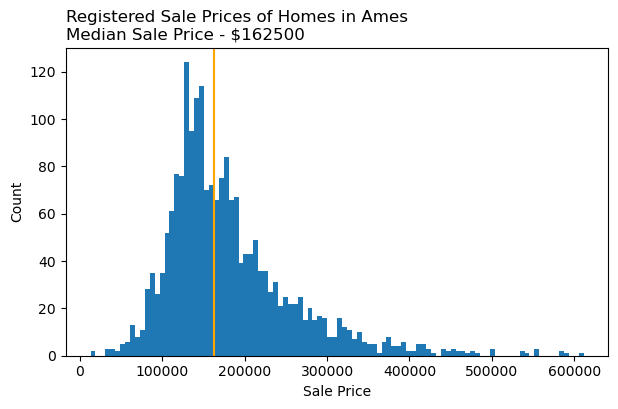

In [7]:
plt.figure(figsize=(7,4))
plt.hist(df['saleprice'], bins = 100)
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.axvline(np.median(df['saleprice']), color='orange')
plt.title('Registered Sale Prices of Homes in Ames \n'+ 
          'Median Sale Price - $162500',loc= 'left')
plt.savefig('../images/price_hist.png');

In [8]:
df.corr()['saleprice'].sort_values(ascending=False).head(20)

saleprice         1.000000
overall_qual      0.800207
gr_liv_area       0.697038
garage_area       0.650270
garage_cars       0.648220
total_bsmt_sf     0.628925
1st_flr_sf        0.618486
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
garage_yr_blt     0.533922
mas_vnr_area      0.512230
totrms_abvgrd     0.504014
fireplaces        0.471093
bsmtfin_sf_1      0.423519
lot_frontage      0.341842
open_porch_sf     0.333476
wood_deck_sf      0.326490
lot_area          0.296566
bsmt_full_bath    0.283662
Name: saleprice, dtype: float64

In [9]:
# is there a column that has like grlivearea but is not grlivearea?
# if so what is the name
df.columns[df.columns.str.contains('gr_liv')]

Index(['gr_liv_area'], dtype='object')

In [10]:
df.corr()['overall_qual'].sort_values(ascending=False).head(20)

overall_qual      1.000000
saleprice         0.800207
year_built        0.602964
garage_cars       0.587423
year_remod/add    0.584654
garage_yr_blt     0.574553
gr_liv_area       0.566701
garage_area       0.563814
total_bsmt_sf     0.548742
full_bath         0.515080
1st_flr_sf        0.477136
mas_vnr_area      0.438685
fireplaces        0.388920
totrms_abvgrd     0.382025
open_porch_sf     0.308855
bsmtfin_sf_1      0.278742
bsmt_unf_sf       0.275773
half_bath         0.274859
wood_deck_sf      0.257081
2nd_flr_sf        0.228152
Name: overall_qual, dtype: float64

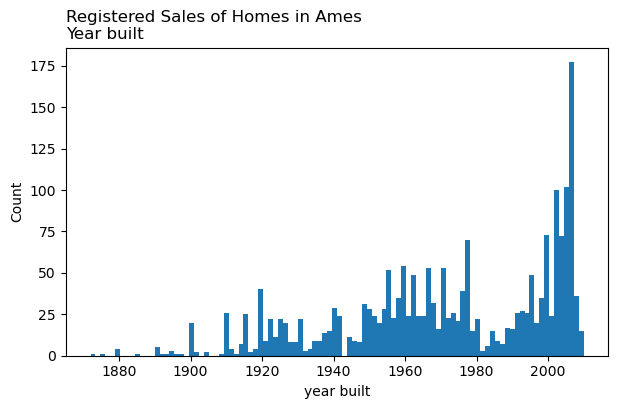

In [11]:
plt.figure(figsize=(7,4))
plt.hist(df['year_built'], bins = 100)
plt.xlabel('year built')
plt.ylabel('Count')
# plt.axvline(np.mean(df['year_built']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Year built',loc= 'left')
plt.savefig('../images/year_built_hist.png');

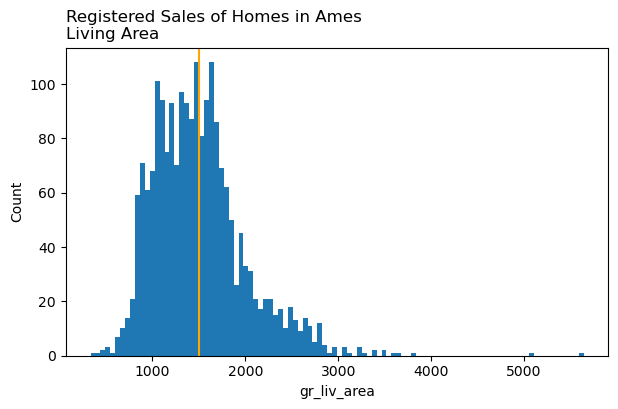

In [12]:
plt.figure(figsize=(7,4))
plt.hist(df['gr_liv_area'], bins = 100)
plt.xlabel('gr_liv_area')
plt.ylabel('Count')
plt.axvline(np.mean(df['gr_liv_area']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Living Area',loc= 'left')
plt.savefig('../images/gr_liv_area_hist.png');

Typical quality columns have values like the ones below and I build a function that applies a map to each similar column that has ordinal values.

In [13]:
df['garage_qual'].value_counts()

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64

#### Next, I will map, clean missing data, make dummy columns, and prepare for feature engineering 
In map_home()map the 'quality' columns to make them ordinal, which is then used to add a quality multiplier to the various types of amenities described in the data. A simple reason for why is this: A garage should increase your house's value if it is in good condition. If it is in disrepair it is a burden and its presence should decrease the sale price. This and other valuation of amenity problems are addressed in the functions I created for this


In numeric_houses() I clean the missing values from numeric columns.


In dummy_houses() I one-hot-encode the categorical variables to create columns that indicate the presence or absence of specific amenities of the property (misc_feature_Shed or misc_feature_TenC for example)
